In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

### Load Frames

In [ ]:
def load_video_frames(path, color=False):
    vid = cv2.VideoCapture(path)
    frames = []
    while vid.isOpened():
        ret, frame = vid.read()
        if not ret:
            break

        conversion = cv2.COLOR_BGR2RGB if color else cv2.COLOR_BGR2GRAY
        frame = cv2.cvtColor(frame, conversion)
        frames.append(frame)
    
    vid.release()
    return np.array(frames)

color_frames = load_video_frames("cropped_cat_video.mp4", color=True)
frames = load_video_frames("cropped_cat_video.mp4")


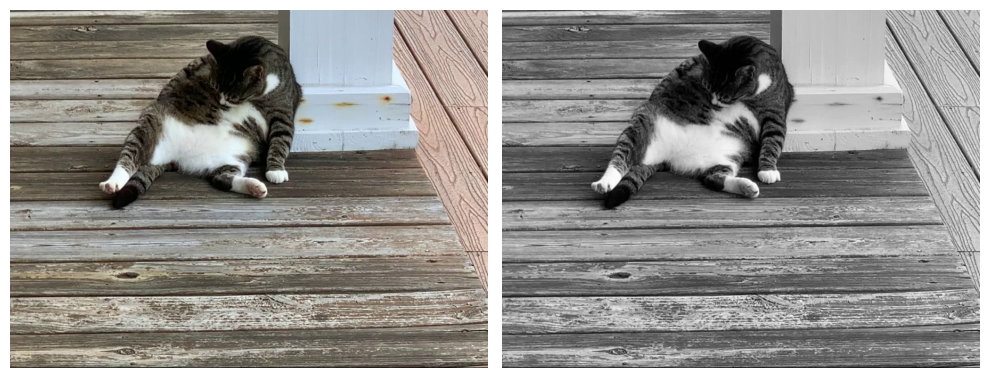

In [96]:
def show_frames(*frames):
    for i, f in enumerate(frames):
        plt.subplot(1, len(frames), i+1)
        plt.imshow(f, cmap="gray")
        plt.axis("off")
    plt.gcf().set_figwidth(10)
    plt.tight_layout()
    plt.show()

show_frames(color_frames[0], frames[0])

### Image Gradient

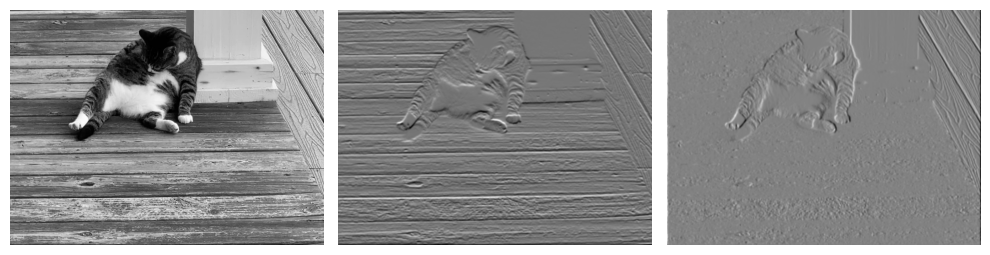

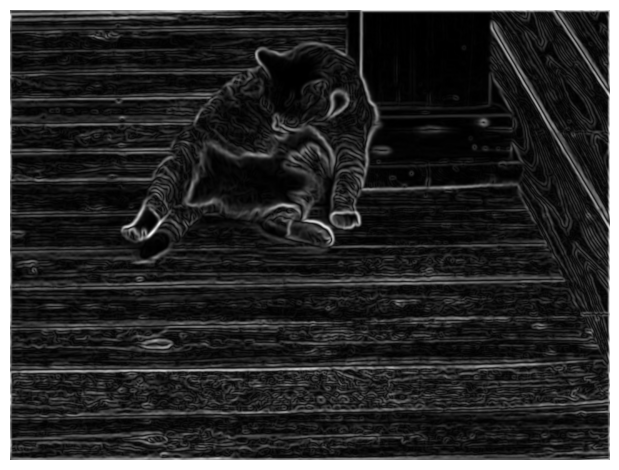

In [109]:
def gaussian_kernel(sigma):
    # determine range for truncation (3.5 sigma)
    h = np.ceil(3.5 * sigma)
    x = np.arange(-h, h + 1, 1)
    # ignore constant in front and normalize after
    kernel = np.exp(-0.5*(x / sigma)**2)
    norm_factor = np.convolve(np.ones_like(kernel), kernel, mode="valid")[0]
    kernel /= norm_factor

    # plt.plot(x, kernel)
    return kernel


def deriv_kernel(sigma):
    # get derivative of gaussian
    # determine range for truncation (3.5 sigma)
    h = np.ceil(3.5 * sigma)
    x = np.arange(-h, h + 1, 1)
    # ignore constant in front because will rescale anyways
    kernel = -x * np.exp(-0.5*(x / sigma)**2)

    # normalize so derivative on a unit ramp is correct
    unit_ramp = x  # by coincidence, we already made a unit ramp of the correct shape
    norm_factor = np.convolve(unit_ramp, kernel, mode="valid")[0]
    kernel /= norm_factor

    # plt.plot(x, kernel)
    return kernel


def image_gradient(frame, sigma=2):
    d_kernel = deriv_kernel(sigma)
    g_kernel = gaussian_kernel(sigma)

    # smooth in one direction and differentiate in the other
    vert_deriv = convolve2d(frame, d_kernel.reshape(-1, 1), mode="same")
    vert_deriv = convolve2d(vert_deriv, g_kernel.reshape(1, -1), mode="same")
    horiz_deriv = convolve2d(frame, d_kernel.reshape(1, -1), mode="same")
    horiz_deriv = convolve2d(horiz_deriv, g_kernel.reshape(-1, 1), mode="same")
    return np.stack((vert_deriv, horiz_deriv), axis=2)

grad = image_gradient(frames[0])
show_frames(frames[0], grad[:,:,0], grad[:,:,1])
grad_mag = np.linalg.norm(grad, axis=2)
show_frames(grad_mag)